In [1]:
%matplotlib inline

# Raw datasets

Accessing raw array data from an experiment.

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11 import H5Data

## hdf5 file

In [3]:
import os 
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
# read hdf5 file
data = H5Data(fil)
data.pprint()

file: 		 C:\Users\Adam\Documents\Git\e11_analysis\notebooks\example_data\array_data.h5 
size: 		 2.78 MB 
num groups: 	 6 
author: 	 AD 
description: 	 Testing oskar data acquisition.


In [4]:
# List the datasets that belong to the group `squid=1`.
print(data.datasets(1))

['AV_0', 'IMG', 'OSC_0']


## Array datasets

### Oscilloscope data

Oscilloscope traces are often stored as 2d arrays of repeating 1d measurements.

In [5]:
# Load 2D array data from the hdf5 file,
squid = 1
arr = data.array(squid, 'OSC_0', ignore_missing=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.82it/s]


This data contains traces of 2501 data points and 25 repeats are stored along the first dimension.


In [6]:
print(np.shape(arr))

(25, 2502)


In [7]:
# information about the dataset.
osc_info = data.attrs(squid, 'OSC_0')
osc_info

{'Averages': 10,
 'Manufacturer': 'LECROY',
 'Model': 'HDO4054',
 'Serial Number': 'LCRY3513N19955',
 'dt': 8.000000106811456e-10,
 'squid': 1}

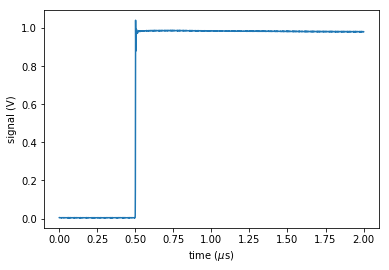

In [8]:
# plot
fig, ax = plt.subplots()

# data
dt = 1e6 * osc_info['dt']
xvals = np.arange(0, len(arr[0])*dt, dt)
yvals = np.mean(arr, axis=0)
ax.plot(xvals, yvals)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (V)')

# output
plt.show()

### Camera data

Camera data are typically stored as 3d arrays of repeating 2d exposures.  Here, the repeats are stored along axis=2, in accordance with the convention of `HDFView`.

In [9]:
# read image datasets
squids = [1, 2]
img = data.array(squids, 'IMG', axis=2, ignore_missing=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.76it/s]


The data contains 19 images of 128 x 128 pixels. Concatenation of multiple squids is performed using `axis=2`.

In [10]:
print(np.shape(img))

(128, 128, 19)


In [11]:
# information about the dataset
camera_info = data.attrs(squid, 'IMG')
camera_info

{'Exposure (ms)': 1000,
 'Manufacturer': 'Sirius Cybernetics Corporation',
 'Model': 'image-o-matic',
 'squid': 1}

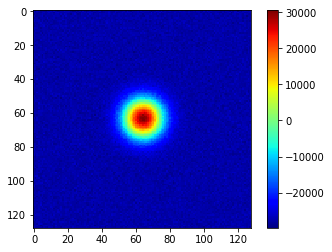

In [12]:
# average image
av_img = np.mean(img, axis=2)
cmap = 'jet'

# plot
fig, ax = plt.subplots()
image = ax.imshow(av_img, cmap=cmap)
cb = plt.colorbar(image)

# output
plt.show()

## Dataframe datasets

Another common data storage format is the dataframe-like structure, i.e., single values stored as rows with headed columns.

In [13]:
# load data from the hdf5 file,
df = data.df(data.squids, 'AV_0', label=None, ignore_missing=False)
df.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 375.24it/s]


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

In this example, AV_0 is the mean oscilloscope signal in a given window.  The window boundaries are stored as dataset attributes, here returned as `df_info`.

In [14]:
df_info = data.attrs(squid, 'AV_0')
df_info

{'A': 2127, 'B': 893, 'C': 646, 'D': 709, 'E': 133, 'F': 437, 'squid': 1}

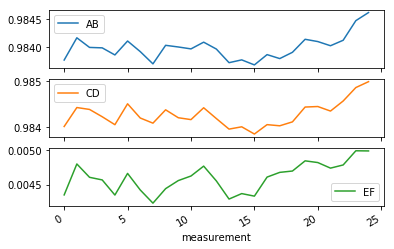

In [15]:
# plot the DataFrame for squid=1
df.loc[1, :].plot(subplots=True)

# output
plt.show()

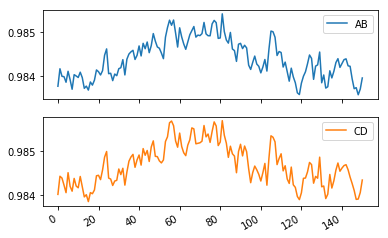

In [16]:
# plot the DataFrame for all squids
df.reset_index()[['AB', 'CD']].plot(subplots=True)

# output
plt.show()

## H5Scan

These class methods are shared by `H5scan`, however, the argument `squid` is not needed as H5Scan is for use with files without groups.

In [17]:
from e11 import H5Scan
fil = os.path.join(os.getcwd(), 'example_data', 'microwave_scan.h5')
scan = H5Scan(fil)

In [18]:
arr2 = scan.array('osc_0')
osc0_info = scan.attrs('osc_0')

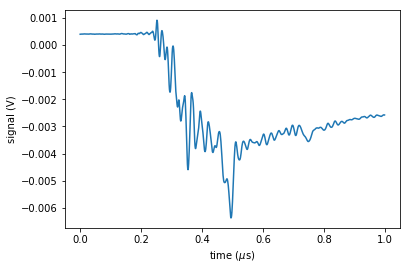

In [19]:
# plot
fig, ax = plt.subplots()

# data
dt = 1e6 * osc0_info['dt']
xvals = np.arange(0, len(arr2[0])*dt, dt)
yvals = np.mean(arr2, axis=0)
ax.plot(xvals, yvals)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (V)')

# output
plt.show()

In [20]:
df2 = scan.df('analysis')
df2.head()

,var,w0,w1,a0,a1,a2,f
measurement,,,,,,,
0,32.0500,777.950119,786.992730,0.000499,-0.005882,-1.118270,-0.006381
1,32.0505,777.950119,786.992729,0.000458,-0.006048,-1.122989,-0.006506
2,32.0510,777.950120,786.992729,0.000443,-0.005974,-1.138911,-0.006417
3,32.0515,777.950119,786.992729,0.000860,-0.005568,-0.995466,-0.006428
4,32.0520,777.950119,786.992729,0.000522,-0.005977,-1.095825,-0.006499


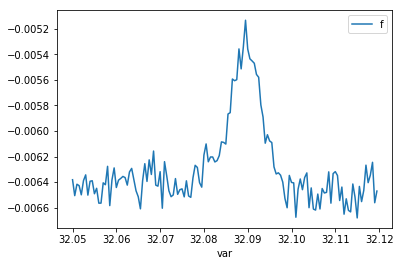

In [21]:
# plot the DataFrame for all squids
df2.sort_values('var').plot('var', 'f')

# output
plt.show()